### <center><font color='blue'>Dev Bharatbhai Patel (8938546)</font></center>
### <center><font color='blue'>Lab-10</font></center>

In [70]:
# Importing necessary packages
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, auc
from keras.utils import to_categorical

1. #### Obtain the Data
    * #### Download the BIRDS 525 SPECIES dataset from Kaggle (CC0 license). You will need to create a free Kaggle account, and this will provide you free access to many such datasets, as well as code and even online notebooks.
    * #### Unpack the data. Notice that the data is organized into folders in a way similar to the Dogs vs Cats dataset that we worked with. This makes it easy to load with the same Keras function (`ImageDataGenerator.flow_from_directory`).

In [49]:
# importing datasets
birds_train = "archive/train"
birds_test = "archive/test"
birds_valid = "archive/valid"

* #### For this lab, we will work with the 3 classes with the highest number of images. Identify those classes, and use only these for the next steps. You can delete/discard the others.

In [50]:
# Firstly, Initialize image count dictionary
image_count = {}

# After that creating a function to count images in a directory
def birds_count_images(dir_path):
    bird_folder = os.scandir(dir_path)
    bird_files = 0
    for path in bird_folder:
        if path.is_file():
            bird_files += 1
    return bird_files

# Now creating another function to count number of images in each sub-directory within a directory
def bird_file_counts(sub_dir_path):
    for bird_folder_2 in os.scandir(sub_dir_path):
        if bird_folder_2.is_dir():
            bird_folder_name = bird_folder_2
            image_count[bird_folder_name] = birds_count_images(bird_folder_2.path)

# Finding image counts for each class in the bird_train folder
bird_file_counts(birds_train)

# Sorting it into descending order
bird_img_sorted = sorted(image_count.items(), key=lambda item: item[1], reverse=True)
top_3_bird = bird_img_sorted[:3]

# creating a list to store the top 3 class
top_3_bird_class = []

# Set top 3 classes in list
for bird_image_name, count in top_3_bird:
    top_3_bird_class.append(str(bird_image_name).split(" '")[1].replace("'>",""))

# Print top 3 classes
print("Top 3 Class:",top_3_bird_class)

Top 3 Class: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


* ##### Removing extra classes

In [51]:
# Deleting other directories from birds_train, birds_test and birds_valid folder
for birds_species in os.listdir(birds_train):
    if birds_species not in top_3_bird_class:
        delete_path_train = os.path.join(birds_train, birds_species)
        shutil.rmtree(delete_path_train)

for birds_species in os.listdir(birds_test):
    if birds_species not in top_3_bird_class:
        delete_path_test = os.path.join(birds_test, birds_species)
        shutil.rmtree(delete_path_test)

for birds_species in os.listdir(birds_valid):
    if birds_species not in top_3_bird_class:
        delete_path_valid = os.path.join(birds_valid, birds_species)
        shutil.rmtree(delete_path_valid)

2. #### Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.

In [52]:
# Setting up the data
birds_train_dataset = image_dataset_from_directory(
    birds_train,
    image_size=(180, 180),
    batch_size=32)
birds_test_dataset = image_dataset_from_directory(
    birds_test,
    image_size=(180, 180),
    batch_size=32)
birds_valid_dataset = image_dataset_from_directory(
    birds_valid,
    image_size=(180, 180),
    batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


* ##### Data Augmentation

In [53]:
# Creating augmented data generators
augmented_data = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# After that train generators
train_generator = augmented_data.flow_from_directory(
    birds_train,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# Than test generators
test_generator = augmented_data.flow_from_directory(
    birds_test,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# Lastly valid generators
validation_generator = augmented_data.flow_from_directory(
    birds_valid,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 744 images belonging to 3 classes.


Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


* ##### Plotting the Augmented Images

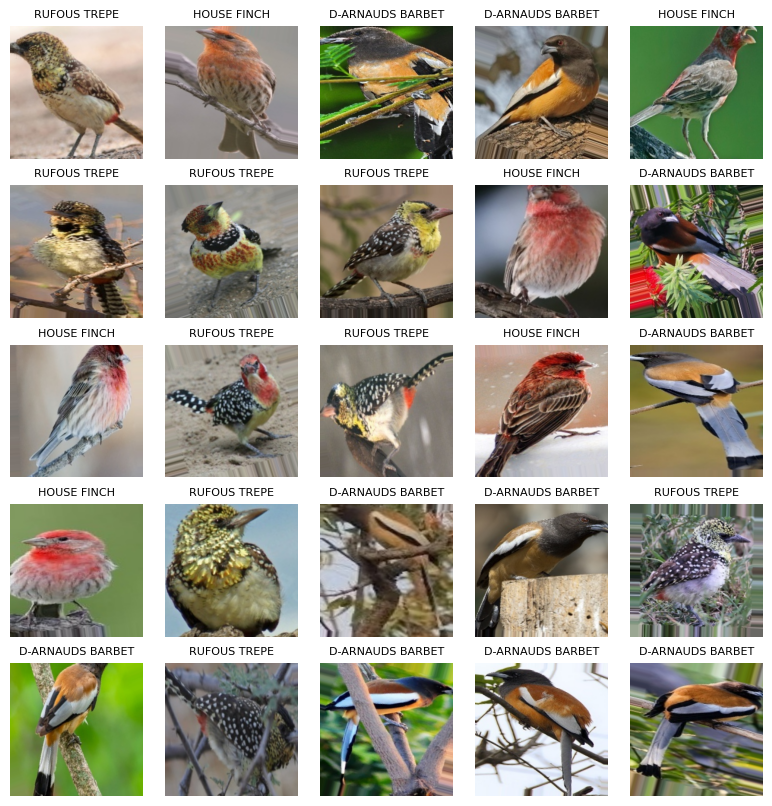

In [54]:
birds_img_labels = {0: 'RUFOUS TREPE', 1:'HOUSE FINCH', 2:'D-ARNAUDS BARBET'}

def display_augmented_images(generator, num_images=25, grid_dim=(5, 5)):
    plt.figure(figsize=(10, 10))
    images, labels = generator.next()
    for i in range(num_images):
        plt.subplot(grid_dim[0], grid_dim[1], i + 1)
        plt.imshow(images[i].astype('uint8'))
        decoded_label = birds_img_labels[np.argmax(labels[i])]
        plt.title(decoded_label, fontsize=8)
        plt.axis("off")

    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()

display_augmented_images(train_generator)

3. #### Fine-Tune `VGG16` (pre-trained on imagenet), to classify the 3 classes.

In [55]:
# Getting VGG16 model with imagenet weights
VGG16_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [56]:
# Creating a function to preprocess the images as features and labels
def get_birds_features_and_labels(dataset):
    # Creating a list for features and labels
    birds_all_features = []
    birds_all_labels = []

    # Creating a for loop over the dataset and extract the features and labels
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = VGG16_model.predict(preprocessed_images)
        birds_all_features.append(features)
        birds_all_labels.append(labels)

    return np.concatenate(birds_all_features), np.concatenate(birds_all_labels)

train_features, train_labels =  get_birds_features_and_labels(birds_train_dataset)
test_features, test_labels =  get_birds_features_and_labels(birds_test_dataset)
val_features, val_labels =  get_birds_features_and_labels(birds_valid_dataset)

1/1 [==============================] - 1s 977ms/step


In [57]:
for layer in VGG16_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = VGG16_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(3, activation='softmax')(x)
custom_model = tf.keras.Model(inputs, outputs)

custom_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_27 (Dense)            (None, 512)               262656    
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 3)                 1539      
                                                           

In [62]:
# Compiling the custom_model with the Adam optimizer, categorical crossentropy loss, and accuracy metric.
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model using fit() method with the train_generator as the training data.
validation_data_run = custom_model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
24/24 [==============================] - 119s 5s/step - loss: 1.7258 - accuracy: 0.8051 - val_loss: 0.5982 - val_accuracy: 0.9333
Epoch 2/10
24/24 [==============================] - 126s 5s/step - loss: 0.2948 - accuracy: 0.9516 - val_loss: 3.6023e-05 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 114s 5s/step - loss: 0.2208 - accuracy: 0.9610 - val_loss: 0.1400 - val_accuracy: 0.9333
Epoch 4/10
24/24 [==============================] - 113s 5s/step - loss: 0.1829 - accuracy: 0.9624 - val_loss: 2.4717e-04 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 115s 5s/step - loss: 0.2041 - accuracy: 0.9637 - val_loss: 1.0495e-04 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 110s 5s/step - loss: 0.1243 - accuracy: 0.9758 - val_loss: 5.6426e-07 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 115s 5s/step - loss: 0.0578 - accuracy: 0.9825 - val_loss: 1.2862e-04 - val_accuracy: 

4. #### Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. 

In [89]:
model_accuracy = validation_data_run.history["accuracy"]
model_validation_accuracy = validation_data_run.history["val_accuracy"]
model_loss = validation_data_run.history["loss"]
model_validation_loss = validation_data_run.history["val_loss"]
epochs = range(1, len(model_accuracy) + 1)

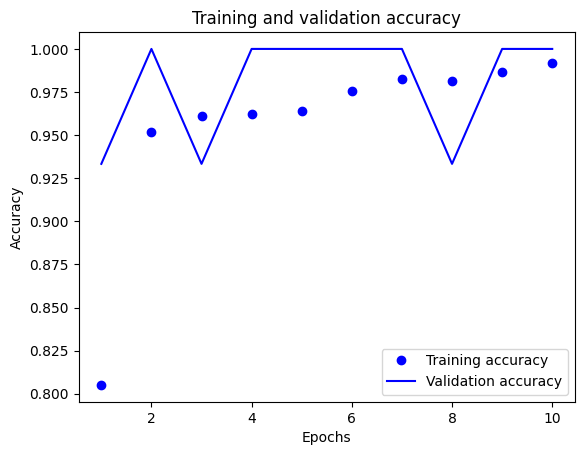

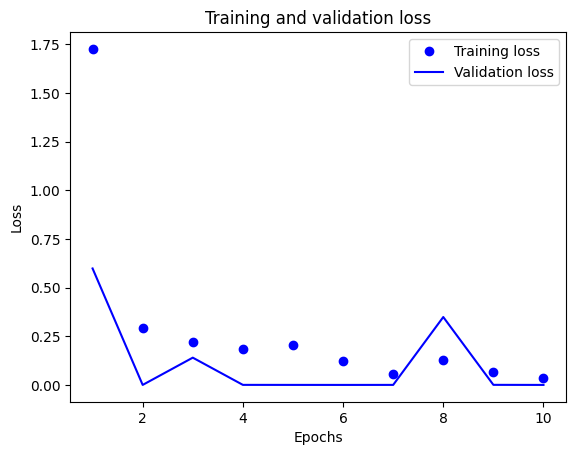

In [90]:
plt.plot(epochs, model_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, model_validation_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, model_loss, "bo", label="Training loss")
plt.plot(epochs, model_validation_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [92]:
model_validation_loss, validation_model_acc = custom_model.evaluate(validation_generator)
print(f'Model validation accuracy: {validation_model_acc}')
print(f'Model validation loss: {model_validation_loss}')

1/1 [==============================] - 2s 2s/step - loss: 7.5734e-06 - accuracy: 1.0000
Model validation accuracy: 1.0
Model validation loss: 7.573354650958208e-06


In [95]:
# Calculating accuracy, confusion matrix, precision, recall, F1-score

test_predictions = custom_model.predict(test_generator)
test_predictions_classes = np.argmax(test_predictions, axis=1)

accuracy = accuracy_score(test_labels, test_predictions_classes)
precision = precision_score(test_labels, 
test_predictions_classes, average='macro')
recall = recall_score(test_labels, test_predictions_classes, average='macro')
f1 = f1_score(test_labels, test_predictions_classes, average='macro')

cm = confusion_matrix(test_labels, test_predictions_classes)

print(f"Test Accuracy: {round(accuracy,4)}")
print(f"Confusion Matrix:\n {cm}")
print(f"Precision: {round(precision,4)}")
print(f"Recall: {round(recall,4)}")
print(f"F1 score: {round(f1,4)}")

class_report = classification_report(test_labels, test_predictions_classes, target_names = train_dataset.class_names)

print(f"Classification Report:\n {class_report}")

1/1 [==============================] - 2s 2s/step
Test Accuracy: 0.2667
Confusion Matrix:
 [[1 1 3]
 [4 1 0]
 [0 3 2]]
Precision: 0.2667
Recall: 0.2667
F1 score: 0.2667
Classification Report:
                   precision    recall  f1-score   support

D-ARNAUDS BARBET       0.20      0.20      0.20         5
     HOUSE FINCH       0.20      0.20      0.20         5
    RUFOUS TREPE       0.40      0.40      0.40         5

        accuracy                           0.27        15
       macro avg       0.27      0.27      0.27        15
    weighted avg       0.27      0.27      0.27        15



* #### Precision-recall curve and its area under the curve (AUC) 

AUC of D-ARNAUDS BARBET: 0.3247
AUC of HOUSE FINCH: 0.3638
AUC of RUFOUS TREPE: 0.4877


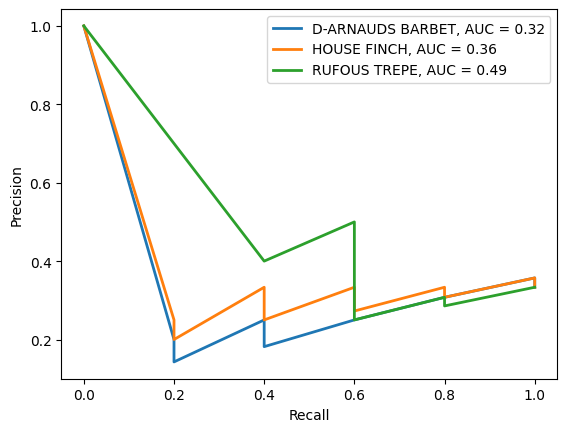

In [96]:
# Converting categorical values to one-hot encoding
y_true_one_hot = to_categorical(test_labels)
class_names = {v: k for k, v in validation_generator.class_indices.items()}

# Calculating precision-recall curve
for i in range(3):
    # Getting the precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], test_predictions[:, i])
    # Calculating the area under the curve
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC of {class_name}: {round(auc_score, 4)}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

* ##### Model failure prediction

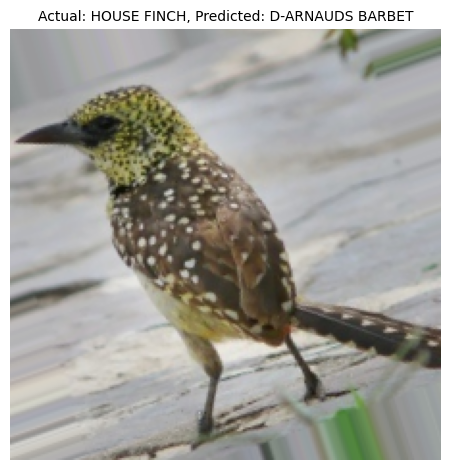

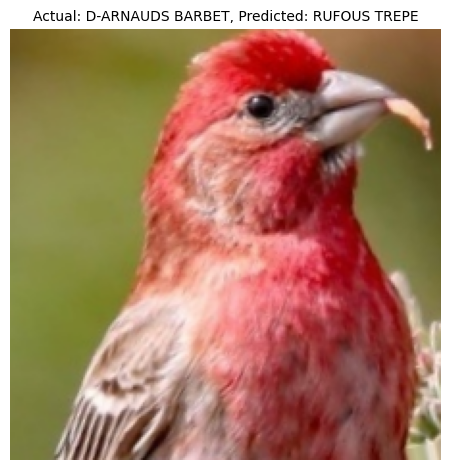

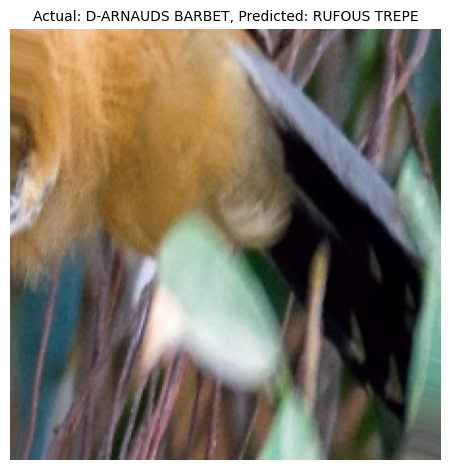

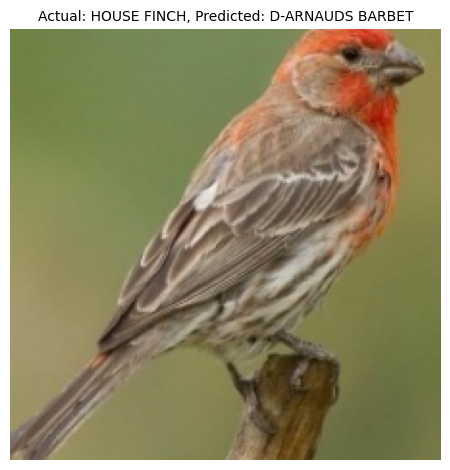

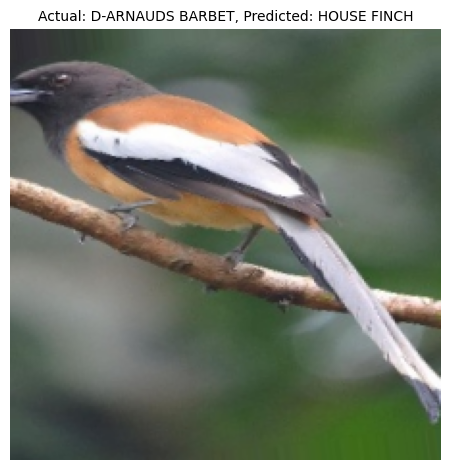

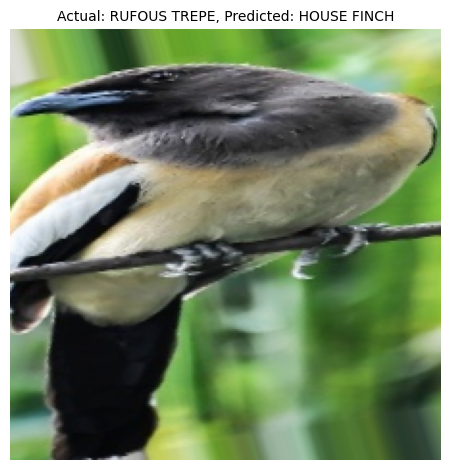

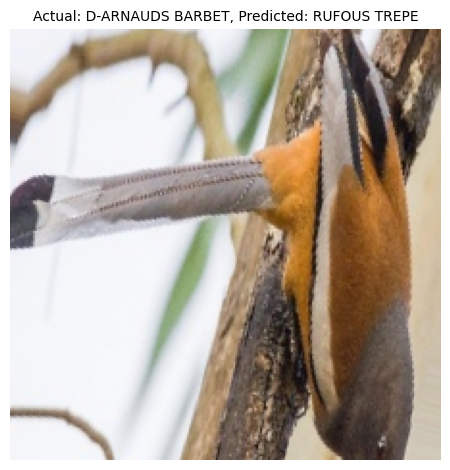

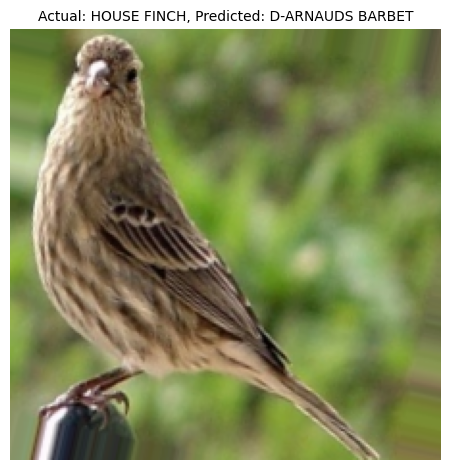

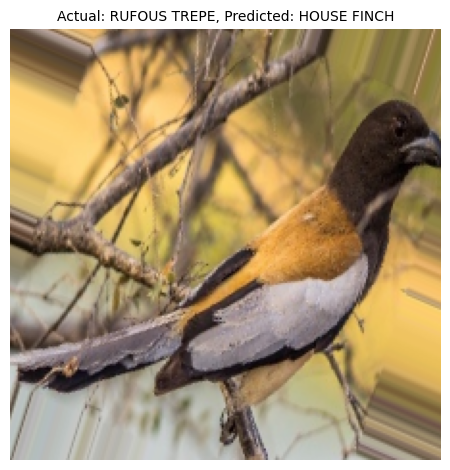

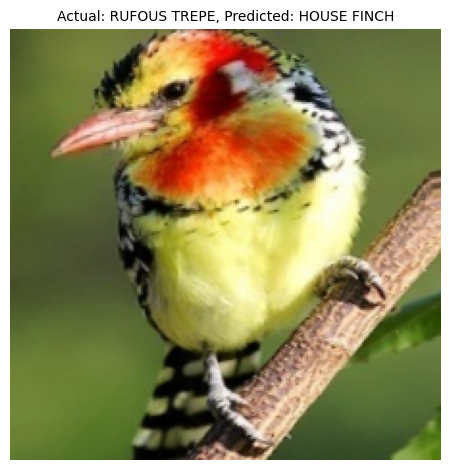

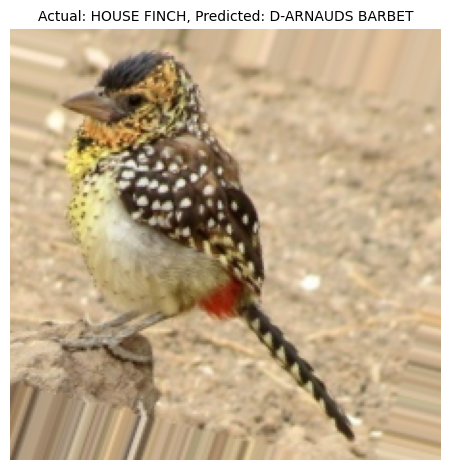

In [98]:
misclassfied_index = np.where(test_predictions_classes != test_labels)[0]

for idx, index in enumerate(misclassfied_index):
    # Getting the image batch after that image
    img_batch, _ = validation_generator[index // validation_generator.batch_size]
    img = img_batch[index % validation_generator.batch_size]
    
    # Getting the true and predicted classes
    true_class_name = class_names[test_labels[index]]
    predicted_class_name = class_names[test_predictions_classes[index]]

    plt.imshow(img.astype('uint8'))
    plt.title(f'Actual: {true_class_name}, Predicted: {predicted_class_name}', fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()